# Reconocimiento de Dígitos 
## (usando KNN y PCA)

En esta notebook veremos cómo reconocer dígitos usando la técnica K-Nearest Neighbors (KNN).

También veremos un poquito de PCA

In [0]:
%matplotlib inline
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


Usaremos la base de datos MNIST. Primero, la bajamos

In [0]:
# Load data from https://www.openml.org/d/554
X_all, y_all = fetch_openml('mnist_784', version=1, return_X_y=True)

y_all = y_all.astype(int)



Veamos qué forma tienen los datos

In [3]:
X_all.shape, y_all.shape

((70000, 784), (70000,))

En `X` tenemos imágenes de 28x28, una por línea (28x28 = 784).
En `y` tenemos a qué clase pertenecen (si es un 0, un 1, un 2, ... así hasta 9)


In [0]:

limit = 10000
X = X_all[:limit]
y = y_all[:limit]

Grafiquémoslos

In [0]:
X[0].shape


(784,)

Supuestamente es un 3


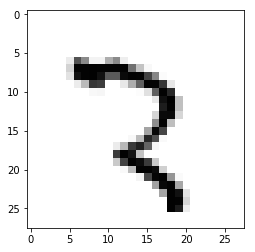

In [0]:
num = 500

print("Supuestamente es un {}".format(y[num]))

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")

### División del dataset entre train y test

Dividimos el dataset entre train y test. Para eso usamos la siguiente función de `sklearn`

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7500, 784), (7500,), (2500, 784), (2500,))

Vamos a implementar esto.

Usualmente los clasificadores (siguiendo la interfaz de [sklearn](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) tienen dos métodos:

- `fit(X, y)` que ajusta("fittea") el modelo a los datos 
- `predict(X)`: dadas observaciones `X` predice sus etiquetas `y`

## Ejercicio

Implementar los métodos fit y predict de KNNClassifier. Tratar de vectorizar las operaciones en la medida de lo posible.

Pensar primero cómo calcular la distancia de un vector a todas las filas de una matriz `X`.

Pueden ser de ayuda las siguientes funciones:

- `np.square`: eleva al cuadrado un array
- `np.sum`: suma un array
- `np.argsort`: devuelve los índices de un array ordenados de menor a mayor
- `np.bincount`:  dado un array de valores no-negativos, calcula cuántas veces vio a cada uno
- `np.argmax`: devuelve el índice cuyo valor es el más grande de un array

In [0]:
A = np.array([
    [1, 1, 1],
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0]
])

x = np.array([1, 1, 1])

np.square(A - x)

array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]])

In [0]:
import numpy as np
from IPython.core.debugger import set_trace


class KNNClassifier:
    def __init__(self, n_neighbors, metric='l2'):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.X = X #sería la crítica
        self.y = y #sería la etiqueta
        
    def _predict_row(self, row):
        A = np.argsort(np.sum((np.square(self.X-row)), axis=1))        
        
        k = np.zeros(self.n_neighbors)
        for i in range(k.shape[0]):
          k[i] = self.y[A[i]]
        
        k = np.bincount(k.astype(int))        
        

        return np.argmax(k)
    
    def predict(self, X, y=None):
        ret = np.zeros(X.shape[0])#vector columna a devolver
        for k, row in enumerate(X):
            ret[k] = self._predict_row(row)
        return ret


Creamos el modelo y lo ajustamos a nuestros datos de entrenamiento

In [0]:

clf = KNNClassifier(n_neighbors=10)

clf.fit(X_train, y_train)


Acá evaluamos cómo nos da el modelo. Esto lo hacemos midiendo la tasa de acierto de las predicciones de nuestro clasificador.

Para eso, primero predecimos `y_pred` y nos fijamos cuántas de esas mediciones dan igual que `y_test`



In [0]:
%%time

from sklearn.metrics import accuracy_score

# Pedimos que prediga los de test...

y_pred = clf.predict(X_test)

# Pedimos 
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.9384
CPU times: user 1min 45s, sys: 6.4 s, total: 1min 51s
Wall time: 1min 51s


Deberían obtener una tasa de acierto > 90%...

Como vemos, se toma su tiempito. ¿Cómo podemos hacer para agilizar el proceso?



## PCA

Vamos a ver una técnica para reducir la dimensionalidad y aún así mantener la mayor cantidad de información posible.

Recordemos que, dada X su matriz de covarianza $M_X$ es

$$ M_X = \frac{X^T X}{n-1} $$

En primer lugar, calculemos la matriz de covarianza de $X_{train}$

In [7]:
import numpy as np

M = (X_train - X_train.mean(axis=0))

print(X_train.shape[0], X_train.shape[1])
print(M.shape[0], M.shape[1])



cov_matrix = M.T @ M / (M.shape[0]-1) 

7500 784
7500 784


Usemos `np.linalg.eig` para diagonalizar la matriz

In [8]:
w, V = np.linalg.eig(cov_matrix)

# A veces aparecen números complejos acá. Los descartamos
w = np.real(w)
V = np.real(V)

print(cov_matrix.shape[0], cov_matrix.shape[1]) 

784 784


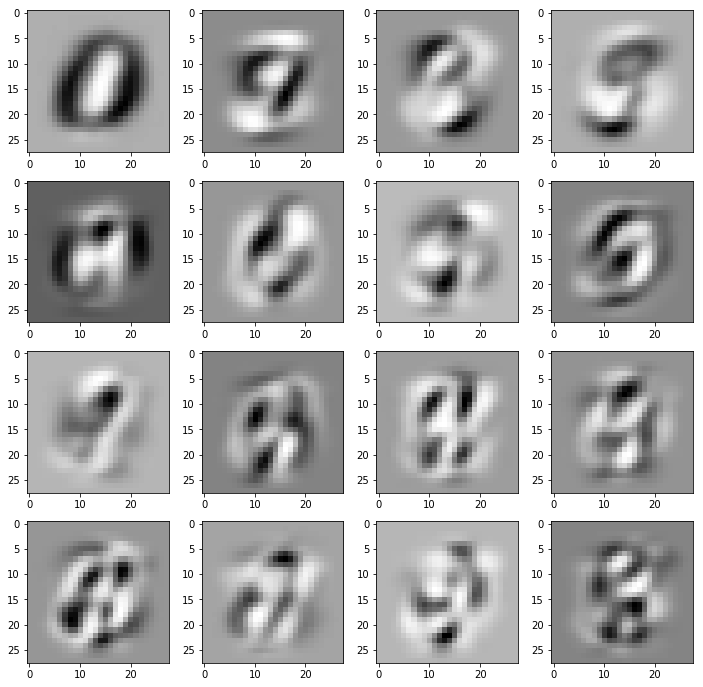

In [0]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(V[:, i].reshape(28, 28), cmap='Greys')

## Recordando cambios de base y otros yuyos

Sup $M_X$ es la matriz de la covarianza, 

$$ M_X = \frac{X^T X}{n-1} $$

Si $B = \{v_1, \ldots , v_n\}$ es la base ortogonal de autovectores de $M_X$ entonces la matriz cambio de base de $B$ a la base canónica ($E$) se escribe como la matriz cuyas columnas son los respectivos vectores

$$C_{B, E} = V = \begin{bmatrix}
        &     & \ldots &     \\
    v_1 & v_2 & \ldots & v_n \\
        &     & \ldots &     \\
\end{bmatrix}
$$


La matriz inversa de ésta es la cambio de base de $E$ a $B$. Es decir $C_{E, B} = C_{B, E}^{-1}$. Como nuestra base es ortogonal, tenemos

$$ C_{E, B} = C_{B, E}^T = V^T = \begin{bmatrix}
& & v_1   & &\\
& & v_2   & &\\
& &\vdots & & \\
& & v_n   & & \\
\end{bmatrix}
$$

Es decir, la matriz que consiste de apilar los vectores fila de la base $B$.


### Cambiando de base nuestras instancias de entrenamiento

Nuestras matrices $X \in R^{n \times m}$ con $n$ igual a la cantidad de instancias de entrenamiento, y $m$ la cantidad de variables

Tenemos entonces

$$ X = \begin{bmatrix}
& & x^{(1)}   & &\\
& & x^{(2)}   & &\\
& &\vdots & & \\
& & v_n   & & \\
\end{bmatrix}
$$

Si $x$ es una instancia de entrenamiento a la cual queremos cambiar de base, queremos hacer

$$\overline x = V^T x$$

Luego, si queremos cambiar de base cada instancia, hacemos...

$$ V^T X^T = V^T \begin{bmatrix}
        & &    & &\\
x^{(1)}& x^{(2)} &\ldots & x ^{(n-1)} & x ^{(n)} \\
& & & & \\
\end{bmatrix} = \begin{bmatrix}
        & &    & &\\
V^T x^{(1)}& V^T x^{(2)} &\ldots & V^T x ^{(n-1)} & V^T x ^{(n)} \\
& & & & \\
\end{bmatrix} = \begin{bmatrix}
        & &    & &\\
\overline{x^{(1)}}& \overline{x^{(2)}} &\ldots & \overline{x^{(n-1)}} & \overline{x^{(n)}} \\
& & & & \\
\end{bmatrix}
$$

Ahora, lo que necesitamos es que cada instancia esté en una fila, así que trasponemos

$$
\overline{X} = (V^T X^T)^T = X V
$$

## Ejercicio:

1. Implementar el cambio de base usando 
2. Experimentar con distintos $\alpha$. ¿Cómo afecta la accuracy de nuestro algoritmo? ¿Es más rápido (en tiempo)?

In [0]:
X_pca_train = X_train @ V[:, :30]
X_pca_test = X_test @ V[:, :30]

Entrenar ahora el clasificador usando estas nuevas instancias[]

In [0]:
clf = KNNClassifier(n_neighbors=10)
clf.fit(X_pca_train, y_train)

In [13]:
%%time
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_pca_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.9528
CPU times: user 3.98 s, sys: 77.9 ms, total: 4.06 s
Wall time: 4.07 s


## Track extra: Autovalores y autovectores

In [0]:
def power_iteration(A, niter=10000):
    """
    Calcula el autovector al autovalor asociado de valor máximo
    
    
    Devuelve (a, v) con a autovalor, y v autovector de A
    """
    v= np.random.rand(A.shape[1])
    
    v = v/ np.linalg.norm(v)
    #v.reshape(1, -1)        
    a= 0    
    for iteration in range(0, niter):      
      v.reshape(-1,1)     
      v = (A @ v / np.linalg.norm((A @ v)))
    a = (v.T @ A @ v) / (v.T @ v)
    return a, v
    
           
    #a = (v.T @ A @ v) / v.T @ v  
    #a = 1
    #v = np.ones(A.shape[0])
    
   


In [0]:
v = np.ones(5)
print(v)

[1. 1. 1. 1. 1.]


Ejemplo: calcular con una matriz que sabemos que es diagonal

In [107]:
import numpy as np
from IPython.core.debugger import set_trace

D = np.diag([5, 4, 3, 2, 1])

v = np.ones((D.shape[0], 1))

v = v / np.linalg.norm(v)#vector v normalizado

#print(np.eye(D.shape[0])) #matriz identidad de dimension filas de D
# Matriz de Householder
B = np.eye(D.shape[0]) - 2 * (v @ v.T)
# Matriz ya diagonalizada
M = B.T @ D @ B
print(B)
power_iteration(M)

[[ 0.6 -0.4 -0.4 -0.4 -0.4]
 [-0.4  0.6 -0.4 -0.4 -0.4]
 [-0.4 -0.4  0.6 -0.4 -0.4]
 [-0.4 -0.4 -0.4  0.6 -0.4]
 [-0.4 -0.4 -0.4 -0.4  0.6]]


(5.000000000000001, array([-0.6,  0.4,  0.4,  0.4,  0.4]))

In [0]:
def eigen(A, num=2, **kwargs):
    """
    Calculamos num autovalores y autovectores usando método de la potencia+deflación
    """
    C = A.copy()
    eigenvalues = []
    eigenvectors = np.zeros((A.shape[0], num))
    for i in range(num):
        a, v = power_iteration(C)                
        C = (C -(a * (v.reshape(-1,1) @ v.reshape(-1,1).T)))        
        eigenvalues.append(a)
        eigenvectors[:, i] = v
          
    return np.array(eigenvalues), eigenvectors


In [125]:

eigen(M, 3)

(array([5., 4., 3.]), array([[-0.6,  0.4,  0.4],
        [ 0.4, -0.6,  0.4],
        [ 0.4,  0.4, -0.6],
        [ 0.4,  0.4,  0.4],
        [ 0.4,  0.4,  0.4]]))